### Do imports

In [ ]:
!pip install rlds dm-reverb mediapy
import cv2
import jax
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import rlds
import mediapy as media
from PIL import Image
from IPython import display
import numpy as np
import imageio
import os

## Load model

In [ ]:
from octo.model.octo_model import OctoModel

model_name = 'finetune_vizonly_small_mse_20240515_165703'
checkpoint_weights_path = f'/home/joshwajones/tpu_octo_ckpts/{model_name}/'
checkpoint_step = 50000

model = OctoModel.load_pretrained(
    checkpoint_weights_path,
    checkpoint_step,
)

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [ ]:
# create RLDS dataset builder
DATASET_VERSIONS = { 
    "8.8.8": "Full dataset with 1% val",
    "8.8.0": "Full dataset with 10% val", 
    "9.9.0": "Pinecone dataset with 10% val",
    "9.9.9": "Pinecone dataset with 1% val",
}
DATASET_VERSION = "9.9.0"
builder = tfds.builder_from_directory(builder_dir=f'/home/joshwajones/tensorflow_datasets/digit_dataset/{DATASET_VERSION}')
ds = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (defaul    t third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
primary_images = [cv2.resize(np.array(step['observation']['image_0']), (256, 256)) for step in steps]
wrist_images = [cv2.resize(np.array(step['observation']['image_1']), (128, 128)) for step in steps]

# extract goal image & language instruction
goal_image = primary_images[-1]
goal_wrist_image = wrist_images[-1]
language_instruction = steps[0]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
wrist_imgs_save = [cv2.resize(np.array(step['observation']['image_1']), (256, 256)) for step in steps]
video = np.concatenate([np.stack(wrist_imgs_save), np.stack(primary_images)], axis=1)
# video=np.stack(images)
imageio.mimsave('./vid.mp4', video, fps=5.0)

Instruction: Grab the object that looks small, brown, round.


In [ ]:
ds = builder.as_dataset(split='val[:1]')

## Run Inference

Next, we will run inference over the images in the episode using the loaded model.
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [ ]:
WINDOW_SIZE = 2

# create `task` dict
# task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                # for language conditioned

In [ ]:
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.tqdm(range(0, len(primary_images) - WINDOW_SIZE + 1)):
    input_images = np.stack(primary_images[step : step + WINDOW_SIZE])[None]
    input_wrist = np.stack(wrist_images[step : step + WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'image_wrist': input_wrist, 
        'timestep_pad_mask': np.array([[True, True]]),
    }

    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(observation, task, rng=jax.random.PRNGKey(0), unnormalization_statistics=model.dataset_statistics["action"])[0]
    # norm_actions = norm_actions[0]   # remove batch
    # actions = (
    #     norm_actions * model.dataset_statistics["bridge_dataset"]['action']['std']
    #     + model.dataset_statistics["bridge_dataset"]['action']['mean']
    # )

    pred_actions.append(actions)
    true_actions.append(
        steps[step+1]['action']
    )

100%|██████████| 63/63 [00:06<00:00,  9.05it/s]


In [ ]:
true_actions = [] 
for step in tqdm.tqdm(range(0, len(primary_images) - WINDOW_SIZE + 1)):
    true_actions.append(
        steps[step+1]['action']
    )

100%|██████████| 63/63 [00:00<00:00, 173842.86it/s]


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

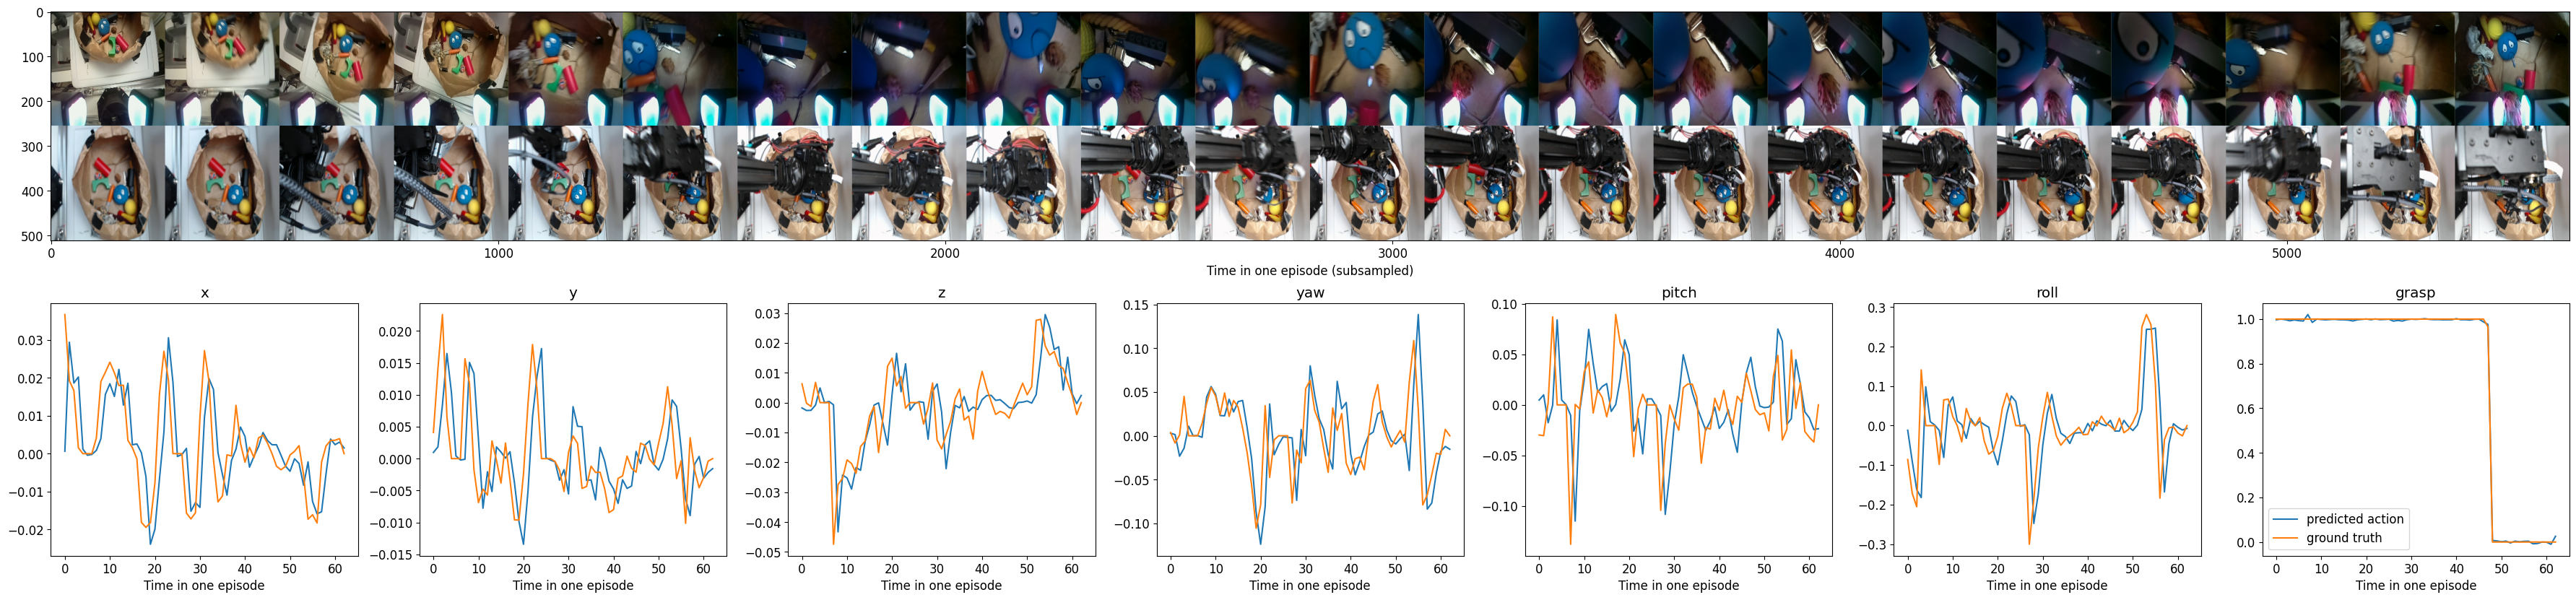

In [ ]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions

img_strip = np.concatenate(np.array(video[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

In [ ]:
model_name = 'test'
fig.savefig(f'./pred_v_true/{model_name}.png')